# Вычисление значения кусочно линейной функции одной переменной 

Мы можем получить кусочно-линейную аппрксимацию выпуклых функций, между точками дискретизации. Что если попробовать использовать их как ограничения.

In [1]:
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray

import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


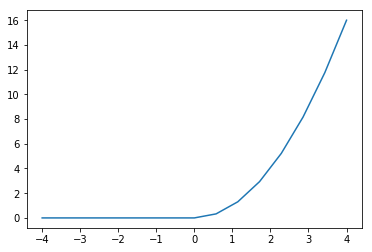

In [2]:
n = 15
a0, b0 = -4, 4
x = np.linspace(a0,b0,n)
y = np.piecewise(x, [x <= 0, x > 0], 
                [0, lambda x: x**2])
plt.plot(x,y)

In [3]:
x

array([-4.        , -3.42857143, -2.85714286, -2.28571429, -1.71428571,
       -1.14285714, -0.57142857,  0.        ,  0.57142857,  1.14285714,
        1.71428571,  2.28571429,  2.85714286,  3.42857143,  4.        ])

Поиск координаты $y$ при заданных $x$ можно свести к решению следующей задачи ЛП:

$$
\min y ,
$$

при условиях:

$$
a_i x + b_i y + c_i \ge 0,\\
x = x_0
$$

Где $a_i$ и $b_i$ --- коэффициенты линейных ограничений функции


Сначала сформируем все ограничения:

In [4]:

y

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.32653061,  1.30612245,
        2.93877551,  5.2244898 ,  8.16326531, 11.75510204, 16.        ])

In [5]:
x_1 = x[:-1:]
x_2 = x[1::]
y_1 = y[:-1:]
y_2 = y[1::]

## Прямая задача

In [6]:

a = (y_1-y_2)
a

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.32653061, -0.97959184, -1.63265306,
       -2.28571429, -2.93877551, -3.59183673, -4.24489796])

In [7]:
b = (x_2-x_1).reshape(-1,1)
b = np.hstack([b,np.zeros_like(b)])
b = np.matrix(b)
b

matrix([[0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ],
        [0.57142857, 0.        ]])

In [8]:
c = x_1*y_2 - x_2*y_1

c

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.37317784,  1.11953353,
        2.23906706,  3.73177843,  5.59766764,  7.83673469])

In [9]:
x_0 = 3
xv = x_0
a*xv + c

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.97959184, -2.56559767, -3.77842566,
       -4.6180758 , -5.0845481 , -5.17784257, -4.89795918])

In [10]:
s = CyClpSimplex()
yv = s.addVariable('y',2)

s += b*yv >= -a*xv - c

s.optimizationDirection = 'min'
s.objective = yv[0]
s.primal()

'optimal'

In [11]:
s.objectiveValue,xv**2

(9.061224489795919, 9)

### Проверка точности
Проверим на многих значениях

In [12]:
def plpp(a,b,c,x):
    s = CyClpSimplex()
    y = s.addVariable('y',2)

    s += b*y >= -a*x - c
        
    s.optimizationDirection = 'min'
    s.objectiveCoefficients = np.array([1,0])
    s.primal()
    
    return s.objectiveValue
plpp(a,b,c,-1)

-9.999999999999998e-13

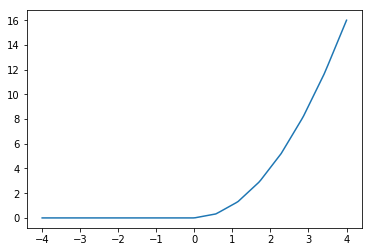

In [13]:
a0,b0 = -4,4
n_res = n*10
x_res = np.linspace(a0,b0,n_res)
y_res = np.empty(n_res)

for i in range(n_res):
    y_res[i] = plpp(a,b,c, x_res[i])

plt.plot(x_res, y_res)

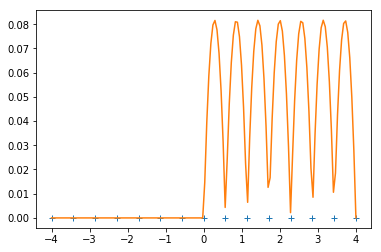

In [14]:
y_test = np.piecewise(x_res, [x_res <= 0, x_res > 0], 
                [0, lambda x: x**2])
plt.plot(x,np.zeros_like(x),'+')
plt.plot(x_res, abs(y_test - y_res))

## Двойственная задача

In [6]:
a = (y_1-y_2)
a

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.32653061, -0.97959184, -1.63265306,
       -2.28571429, -2.93877551, -3.59183673, -4.24489796])

In [27]:
b = (x_2-x_1)
b = np.matrix(b)
b

matrix([[0.57142857, 0.57142857, 0.57142857, 0.57142857, 0.57142857,
         0.57142857, 0.57142857, 0.57142857, 0.57142857, 0.57142857,
         0.57142857, 0.57142857, 0.57142857, 0.57142857]])

In [8]:
c = x_1*y_2 - x_2*y_1
c

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.37317784,  1.11953353,
        2.23906706,  3.73177843,  5.59766764,  7.83673469])

In [22]:
def plpd(a,b,c,x):
    s = CyClpSimplex()
    u = s.addVariable('u',n-1)

    s += b*u <= 1
    
    for i in range(n-1):
        s += u[i] >= 0

    
    s.optimizationDirection = 'max'
    s.objectiveCoefficients = -a*x - c
    s.primal()
    
    return s.objectiveValue
plpd(a,b,c,2)

4.0816326530612255

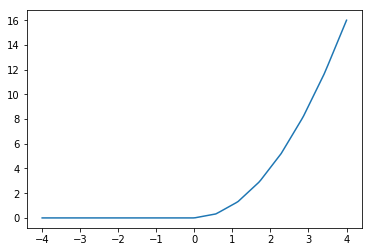

In [23]:
a0,b0 = -4,4
n_res = n*10
x_res = np.linspace(a0,b0,n_res)
y_res = np.empty(n_res)

for i in range(n_res):
    y_res[i] = plpd(a,b,c, x_res[i])

plt.plot(x_res, y_res)

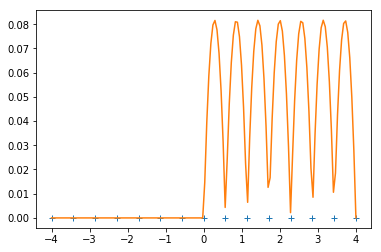

In [24]:
y_test = np.piecewise(x_res, [x_res <= 0, x_res > 0], 
                [0, lambda x: x**2])
plt.plot(x,np.zeros_like(x),'+')
plt.plot(x_res, abs(y_test - y_res))

## Прямая и двойственная задачи

In [55]:
def plppd(a,b,c,x):
    s = CyClpSimplex()
    y = s.addVariable('y',2)
    u = s.addVariable('u',n-1)
    
    bp = b.reshape(-1,1)
    bp = np.hstack([bp,np.zeros_like(bp)])
    bp = np.matrix(bp)
    z = np.matrix(-c-a*x)
    
    s += y - z*u == 0
    s += bp*y >= -a*x - c
    s += b*u <= 1
    
    for i in range(n-1):
        s += u[i] >= 0

    
    s.optimizationDirection = 'max'
    s.objectiveCoefficients = y[0]
    s.primal()
    
    return s.objectiveValue
plppd(a,b,c,1)

1.0612244897959182

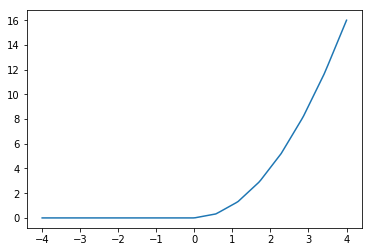

In [36]:
a0,b0 = -4,4
n_res = n*10
x_res = np.linspace(a0,b0,n_res)
y_res = np.empty(n_res)

for i in range(n_res):
    y_res[i] = plppd(a,b,c, x_res[i])

plt.plot(x_res, y_res)

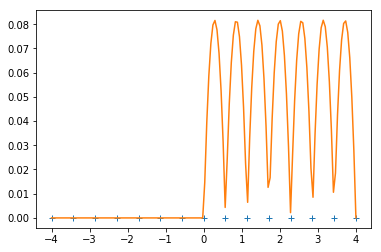

In [37]:
y_test = np.piecewise(x_res, [x_res <= 0, x_res > 0], 
                [0, lambda x: x**2])
plt.plot(x,np.zeros_like(x),'+')
plt.plot(x_res, abs(y_test - y_res))

In [66]:
def plppd(a,b,c,x1,x2):
    s = CyClpSimplex()
    y = s.addVariable('y',2)
    u = s.addVariable('u',n-1)
    
    bp = b.reshape(-1,1)
    bp = np.hstack([bp,np.zeros_like(bp)])
    bp = np.matrix(bp)
    z = np.matrix(-c-a*x1)
    
    s += y - z*u == 0
    s += bp*y >= -a*x2 - c
    s += b*u <= 1
    
    for i in range(n-1):
        s += u[i] >= 0

    
    s.optimizationDirection = 'max'
    s.objectiveCoefficients = y[0]
    s.primal()
    
    return s.objectiveValue
plppd(a,b,c,0,-1)

0.0